Code taken from https://github.com/mahakal001/reinforcement-learning/tree/master/cartpole-dqn

Modified slightly to make neural network structure more clear.

In [1]:
!pip3 install gym
!pip3 install seaborn

In [23]:
import torch
from torch import nn
import copy
from collections import deque
from tqdm import tqdm
import random
import gym
import seaborn as sns
import matplotlib.pyplot as plt

class DQN_Agent:

    def __init__(self, lr, sync_freq, exp_replay_size):
        torch.manual_seed(1234)
        
        self.q_net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
        self.q_net.cuda()

        self.target_net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )        
        
        self.target_net.cuda()
        
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen=exp_replay_size)
        return

    # Returns the best action according to the q network
    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # durin gexperience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q, A = torch.max(Qp, axis=0)
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    # Returns Q value for next state using target network
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q, _ = torch.max(qp, axis=1)
        return q

    # Adds an experience to the experience pool
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    # Returns a sample from the experience pool
    # These are the batches that are used to train the neural network.
    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        
        # state 
        s = torch.tensor([exp[0] for exp in sample]).float()
        
        # action
        a = torch.tensor([exp[1] for exp in sample]).float()
        
        # reward
        rn = torch.tensor([exp[2] for exp in sample]).float()
        
        # next state
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        if self.network_sync_counter == self.network_sync_freq:
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0

        # predict expected return of current state using main network
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)

        # get target return using target network
        q_next = self.get_q_next(sn.cuda())
        target_return = rn.cuda() + self.gamma * q_next

        # Apply loss function as mean-squared error between the two
        loss = self.loss_fn(pred_return, target_return)
        
        # Backward propagate loss to update weights
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        self.network_sync_counter += 1
        return loss.item()

env = gym.make('CartPole-v0')
input_dim = 4
output_dim = 2

exp_replay_size = 256
agent = DQN_Agent(lr=1e-3, sync_freq=5, exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 10000
epsilon = 1

# initiliaze experience replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), reward_list.append(rew)
    episode_len_list.append(ep_len), epsilon_list.append(epsilon)

#sns.lineplot(y=episode_len_list, x=[x for x in range(len(episode_len_list))])
#plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:21<00:00, 38.31it/s]


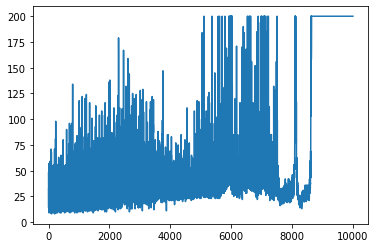

In [13]:
sns.lineplot(y=episode_len_list, x=[x for x in range(len(episode_len_list))])
plt.show()